# Conditional Diffusion Generation

This notebook / script builds a toy conditional diffusion model and learns a data distribution from scratch.

The learned data is the [`keremberke/blood-cell-object-detection`](https://huggingface.co/datasets/keremberke/blood-cell-object-detection) *toy* (364 images) dataset.

# Environment

Determine wether running in Colab or not.

In [55]:
RUNNING_IN_COLAB = (
    "google.colab" in str(get_ipython())
    if hasattr(__builtins__, "__IPYTHON__")
    else False
)
print("Running in COLAB:", RUNNING_IN_COLAB)

Running in COLAB: False


# Imports

# External imports

In [56]:
if RUNNING_IN_COLAB:
    !pip -q install datasets diffusers["torch"] torchinfo

In [57]:
from math import ceil

import numpy as np
import torch
from datasets import load_dataset
from diffusers import DDIMPipeline, DDIMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from PIL import Image
from torch import nn
from torchinfo import summary
from torchvision import transforms
from tqdm.auto import trange

## Local imports

In [57]:
if RUNNING_IN_COLAB:
    import numpy as np
    import torchvision
    from PIL import Image


    def show_images(x):
        """Given a batch of images x, make a grid and convert to PIL"""
        x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
        grid = torchvision.utils.make_grid(x)
        grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
        grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
        return grid_im


    def make_grid(images, size=64):
        """Given a list of PIL images, stack them together into a line for easy viewing"""
        output_im = Image.new("RGB", (size * len(images), size))
        for i, im in enumerate(images):
            output_im.paste(im.resize((size, size)), (i * size, 0))
        return output_im
else:
    %load_ext autoreload
    %autoreload 2
    from utils import show_images

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Device

In [58]:
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print("Using", device)

Using cuda


# Toy Dataset

The 3 splits will be concatenated to train on the full data since the dataset is small and we train from scratch.  
Minimal data augmentation is performed on-the-fly.

In [6]:
# train on *full* data
ds_global = load_dataset("keremberke/blood-cell-object-detection", "full")
train_dataset = ds_global["train"]
test_dataset = ds_global["test"]
validation_dataset = ds_global["validation"]

full_dataset = torch.utils.data.ConcatDataset(
    [train_dataset, test_dataset, validation_dataset]
)

KeyboardInterrupt: 

In [ ]:
full_dataset.datasets

In [ ]:
random_img = np.random.choice(len(full_dataset.datasets[0].to_list()))
Image.open(full_dataset.datasets[0].to_list()[random_img]["image"]["path"])

In [62]:
# square images of size image_size x image_size
image_size = 32

# Data cleaning / augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


train_dataset.set_transform(transform)
test_dataset.set_transform(transform)
validation_dataset.set_transform(transform)

NameError: name 'train_dataset' is not defined

In [61]:
# Create a dataloader to serve up the transformed images in batches
batch_size = 100
nb_batches = ceil(len(full_dataset) / batch_size)

dataloader = torch.utils.data.DataLoader(
    full_dataset, batch_size=batch_size, shuffle=True
)

Show a small (random) batch of images (not necessarily of size `batch_size`!) 

In [ ]:
tmp_bs = 8
xb = next(iter(dataloader))["images"].to(device)[:tmp_bs]
print("X shape:", xb.shape)
show_images(xb).resize((tmp_bs * 128, 128), resample=Image.NEAREST)

# Scheduler

Choices for `DDIMScheduler` are `linear`, `squaredcos_cap_v2` and `scaled_linear`.

In [60]:
num_train_timesteps = 1000
beta_start = 0.0001
beta_end = 0.02
beta_schedule = "linear"  # TODO: understand why cosine schedule is called that way...

noise_scheduler = DDIMScheduler(
    num_train_timesteps=num_train_timesteps,
    beta_start=beta_start,
    beta_end=beta_end,
    beta_schedule=beta_schedule,
)

Let's visualize the scheduler:

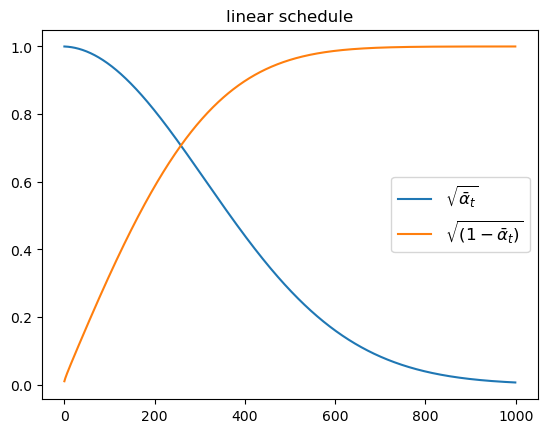

In [33]:
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="large")
plt.title(f"{beta_schedule} schedule")
plt.show()

and how it adds noise to the data:

In [ ]:
timesteps = torch.linspace(0, 999, tmp_bs).long().to(device)
noise = torch.randn_like(xb)
x0_repeated = xb[0].view((1, 3, image_size, image_size)).repeat(tmp_bs, 1, 1, 1)
noisy_example = noise_scheduler.add_noise(x0_repeated, noise, timesteps)
print("Noisy X shape", noisy_example.shape)
show_images(noisy_example).resize((tmp_bs * 128, 128), resample=Image.NEAREST)

$\rightarrow$ Question: optimal noise schedule?

# Model

We use a UNet-like architecture with 4 down and upsampling blocks with self-attention down the U.

In [63]:
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device)
# Sample a random timestep for each image
timesteps = torch.randint(0, num_train_timesteps, (1,), device=device).long()
summary(
    model, (batch_size, 3, image_size, image_size), timestep=timesteps, device=device
)

/home/warpig/.micromamba/envs/diffusion-experiments/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/home/warpig/.micromamba/envs/diffusion-experiments/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                        Output Shape              Param #
UNet2DModel                                   [100, 3, 32, 32]          --
├─Timesteps: 1-1                              [100, 64]                 --
├─TimestepEmbedding: 1-2                      [100, 256]                --
│    └─Linear: 2-1                            [100, 256]                16,640
│    └─SiLU: 2-2                              [100, 256]                --
│    └─Linear: 2-3                            [100, 256]                65,792
├─Conv2d: 1-3                                 [100, 64, 32, 32]         1,792
├─ModuleList: 1-4                             --                        --
│    └─DownBlock2D: 2-4                       [100, 64, 16, 16]         --
│    │    └─ModuleList: 3-1                   --                        181,120
│    │    └─ModuleList: 3-2                   --                        36,928
│    └─DownBlock2D: 2-5                       [100, 128, 8, 8]          --


The model is compiled (will only work with `torch>=2.0.0`); this will take quite some time at first pass.

In [11]:
if hasattr(torch, "compile"):
    model = torch.compile(
        model, mode="reduce-overhead"
    )  # reduce-overhead for quick compile
    # TODO: try max-autotune?
else:
    print("Skipping compilation, since torch.compile is not available")

In [21]:
import time
from pathlib import Path

epoch = 42
import os


timestamp = time.gmtime()
timestamp_str: str = time.strftime("%Y-%m-%dT%H:%M:%SZ", timestamp)

this_experiment_folder = (
    f"experiments/run_{timestamp_str}"
    + ("_" * ("test" != ""))
    + "test".replace(" ", "_")
)
save_folder = Path(this_experiment_folder, "checkpoints", f"epoch_{epoch}")
print(save_folder)
os.makedirs(save_folder)
torch.save(model.state_dict(), Path(save_folder, "unet.pt"))

experiments/run_2023-04-27T17:40:27Z_test/checkpoints/epoch_42


In [24]:
.keys()

odict_keys(['_orig_mod.conv_in.weight', '_orig_mod.conv_in.bias', '_orig_mod.time_embedding.linear_1.weight', '_orig_mod.time_embedding.linear_1.bias', '_orig_mod.time_embedding.linear_2.weight', '_orig_mod.time_embedding.linear_2.bias', '_orig_mod.down_blocks.0.resnets.0.norm1.weight', '_orig_mod.down_blocks.0.resnets.0.norm1.bias', '_orig_mod.down_blocks.0.resnets.0.conv1.weight', '_orig_mod.down_blocks.0.resnets.0.conv1.bias', '_orig_mod.down_blocks.0.resnets.0.time_emb_proj.weight', '_orig_mod.down_blocks.0.resnets.0.time_emb_proj.bias', '_orig_mod.down_blocks.0.resnets.0.norm2.weight', '_orig_mod.down_blocks.0.resnets.0.norm2.bias', '_orig_mod.down_blocks.0.resnets.0.conv2.weight', '_orig_mod.down_blocks.0.resnets.0.conv2.bias', '_orig_mod.down_blocks.0.resnets.1.norm1.weight', '_orig_mod.down_blocks.0.resnets.1.norm1.bias', '_orig_mod.down_blocks.0.resnets.1.conv1.weight', '_orig_mod.down_blocks.0.resnets.1.conv1.bias', '_orig_mod.down_blocks.0.resnets.1.time_emb_proj.weight', '_

: 

# Training loop

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
# TODO: use learning rate scheduler?

nb_epochs = 2

# TODO: use mixed precision!

loss_func = nn.L1Loss()

## Hyperparameters logging

In [ ]:
log_msg = f"image_size: {image_size}\nbatch_size: {batch_size}"
log_msg += f"\n\nnoise_scheduler: {noise_scheduler}"
log_msg += f"\n\nmodel: {model}"
log_msg += f"\n\nloss: {loss_func}"
log_msg += f"\n\noptimizer: {optimizer}\n\nnb_epochs: {nb_epochs}"
print(log_msg)

## Loop

In [ ]:
# keep track of the losses
losses_per_iter = []

iterator = trange(nb_epochs)

for epoch in iterator:
    losses_per_iter.append(0)  # init loss value for this new epoch
    for step, batch in enumerate(dataloader):
        clean_images = batch["images"].to(device)
        # Sample Gaussian noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]  # actual batch size

        # Sample a random timestep for each image
        # (thus "double" stochasticity)
        timesteps = torch.randint(
            0, num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction (not the noisy image, but the noise itself)
        # TODO: try velocity model
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Compute the loss
        loss = loss_func(noise_pred, noise)

        # Compute gradients
        loss.backward(loss)

        # Save loss
        loss_value = float(loss.item())
        losses_per_iter[-1] += (loss_value - losses_per_iter[-1]) / (
            step + 1
        )  # running mean of batch losses for this epoch
        iterator.set_description(
            f"Current batch: {step+1}/{nb_batches} – batch loss: {round(loss_value, 5)} | Epoch:"
        )

        # Update model parameters
        # TODO: try gradient accumulation if memory bound
        optimizer.step()
        optimizer.zero_grad()

    # !nvidia-smi
    print(f"Epoch:{epoch+1}, loss: {losses_per_iter[-1]}")

In [ ]:
if device =="cuda":
    !nvidia-smi

## Loss plot

In [ ]:
plt.style.use("ggplot")
plt.plot(list(range(1, nb_epochs + 1)), losses_per_iter, label="mean loss of epoch")
# moving average
window_width = 10
cumsum_vec = np.cumsum(np.insert(losses_per_iter, 0, 0))
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
plt.plot(
    list(range(window_width, nb_epochs + 1)),
    ma_vec,
    label="running average of epoch losses",
)
plt.xlabel("iteration")
plt.ylabel("average MSE loss")
plt.yscale("log")
plt.legend()
plt.show()

# Pipeline

In [ ]:
image_pipe = DDIMPipeline(unet=model, scheduler=noise_scheduler)

In [ ]:
pipeline_output = image_pipe()
img = pipeline_output.images[0]

In [ ]:
display(img.resize((300, 300), Image.NEAREST))

In [54]:
model

NameError: name 'model' is not defined

# BBBC021 dataset 

Show a small (random) batch of images (not necessarily of size `batch_size`!) 

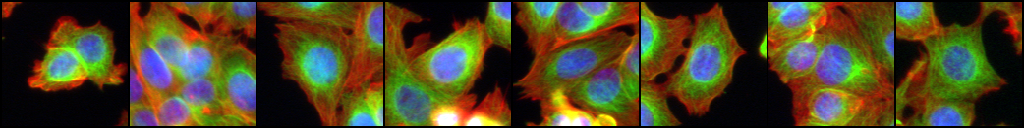

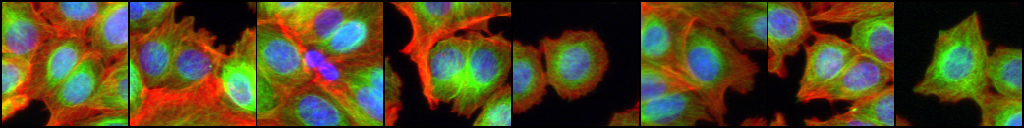

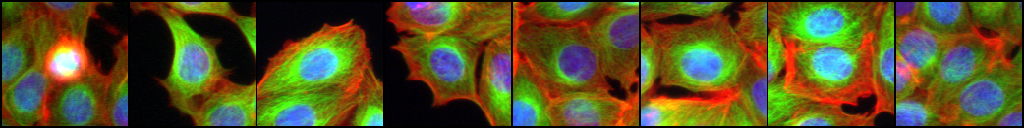

X shape: torch.Size([8, 3, 128, 128])


In [20]:
tmp_bs = 8
nb_rows = 3
for _ in range(nb_rows):
    xb = next(iter(dataloader))["images"][:tmp_bs]
    im_grid = show_images(xb).resize((tmp_bs * 128, 128), resample=Image.NEAREST)
    display(im_grid)
print("X shape:", xb.shape)